In [3]:
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
# import plotly.graph_objects as go
# import plotly.express as px
import ast
# from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    meta_data = data[0][1]
    return data, meta_data


In [5]:
sampling_rate=100
path='/'

Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [7]:
X, meta_data = load_raw_data(Y, sampling_rate, path)

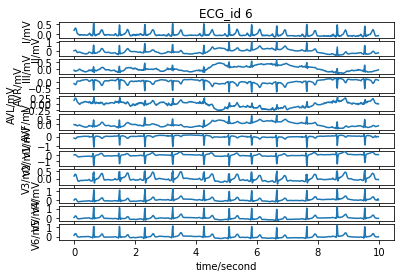

None

In [10]:
record = wfdb.rdrecord(Y.filename_lr.iloc[10])
display(wfdb.plot_wfdb(record=record, title=f'ECG_id {Y.index[5]}'), )

In [18]:
print(X.shape)
print(X[0].T.shape)

(21799, 1000, 12)
(12, 1000)


(0.0, 1000.0)

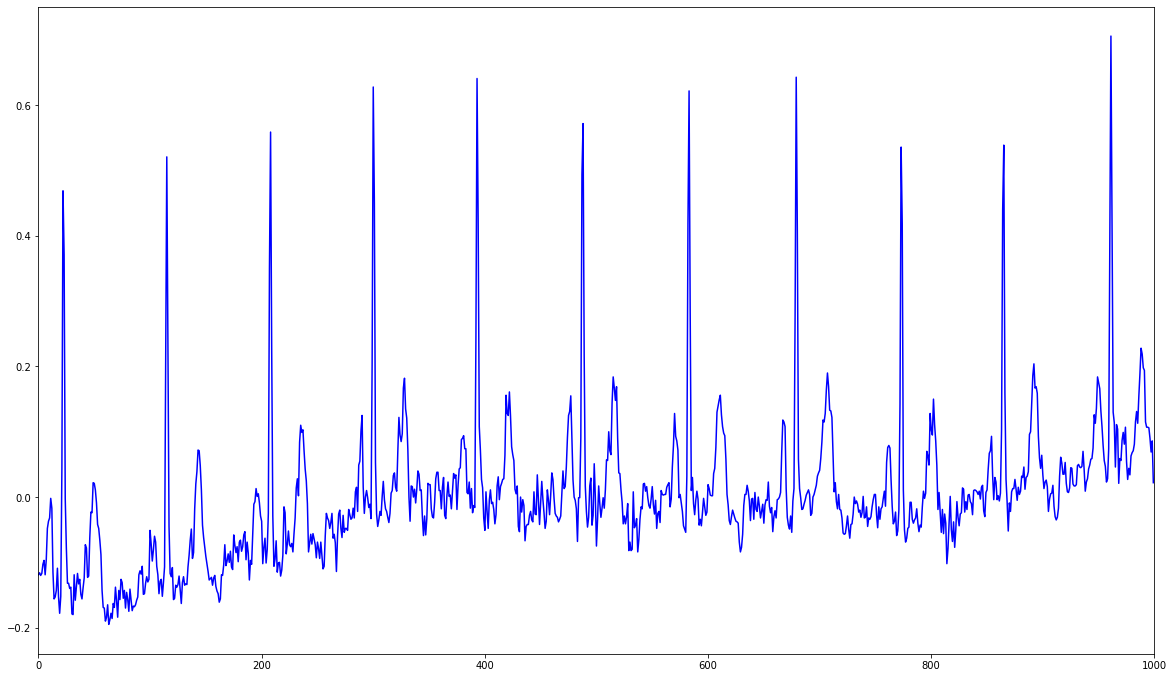

In [24]:
fig = plt.figure(figsize=(20, 50))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
arr_signal.plot((X[0].T)[0][:], color = 'blue')
arr_signal.set_xlim(0, 1000)

PRE-PROCESSING STEP

baseline wander removal

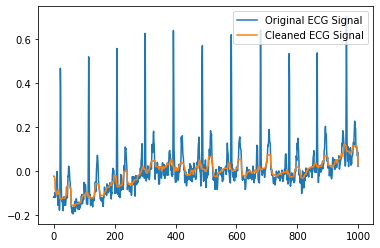

In [32]:
import numpy as np
from scipy.signal import medfilt


# Apply baseline wander removal using a median filter
baseline = np.median(X[0].T[0][:], axis=0)
ecg_clean = X[0].T[0][:] - baseline
ecg_clean = medfilt(ecg_clean, kernel_size=21)

plt.plot(X[0].T[0][:], label='Original ECG Signal')
plt.plot(ecg_clean, label='Cleaned ECG Signal')
plt.legend()

In [20]:
agg_df = pd.read_csv('scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# agg_df.head()

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y.diagnostic_superclass.to_csv('diagnostic_superclass', index=None)

In [ ]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [ ]:
path = Y.filename_lr.iloc[0]
record = wfdb.rdsamp(path)
# display(wfdb.plot_wfdb(record=record))
channels = record[1]['sig_name']

FEATURE EXTRACTION

In [ ]:
from ecgdetectors import Detectors
detectors = Detectors(sampling_rate)

# Padding to help detect initial peaks:
r_peaks = np.array(detectors.hamilton_detector(np.hstack((np.zeros(10),X_train[0,:,1])))) - 10
r_peaks_wvt = np.array(detectors.swt_detector(np.hstack((np.zeros(20),X_train[0,:,1])))) - 20

print(r_peaks)
print(r_peaks_wvt)


[ 28 120 213 306 399 490 588 685 779 867 963]
[ 19  56 112 199 297 390 484 579 675 770 861 957]


In [ ]:
import neurokit2 as nk
u, rpeaks = nk.ecg_peaks(X_train[0,:,1], sampling_rate=sampling_rate)
print(rpeaks)

{'ECG_R_Peaks': array([115, 208, 300, 393, 487, 583, 679, 773, 864, 961]), 'sampling_rate': 100}


In [ ]:
import neurokit2 as nk
from ecgdetectors import Detectors
import sys

def advanced_interactive_signal_plot(idxs: np.array, X: np.array, Y: pd.DataFrame, sampling_rate: int, channels = np.arange(12, dtype = np.int32), rpeak_style = 'nk') -> None:
  channel_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

  colors = px.colors.qualitative.Dark24
  for s_idx in idxs: # subject_index:
    X_subject = X[s_idx, :, :]
    scp_code = Y.scp_codes.iloc[s_idx]
    ecg_id = Y.index[s_idx]

    heart_rates = {}

    fig = go.Figure()
    for n_idx, idx in enumerate(channels):
      fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = X_subject[:,idx] + 2. * (len(channels) - n_idx), name = channel_names[idx], marker_color = colors[idx]))
      fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = np.zeros(X_subject.shape[0]) + 2. * (len(channels) - n_idx), marker_color = 'black', line = dict(width = 1.),  showlegend = False))
      
      # Estimate R-peaks:
      if rpeak_style == 'nk':
        _, rpeaks = nk.ecg_peaks(X_subject[:,idx], sampling_rate=sampling_rate)
        rpeaks = rpeaks['ECG_R_Peaks'].astype('float') / sampling_rate
      elif rpeak_style == 'hamilton':
        detectors = Detectors(sampling_rate)
        rpeaks = (np.array(detectors.hamilton_detector(X_subject[:,idx]))).astype('float')  / sampling_rate # np.hstack((np.zeros(10),
      elif rpeak_style == 'wvt':
        detectors = Detectors(sampling_rate)
        rpeaks = np.array(detectors.swt_detector(X_subject[:,idx])).astype('float') / sampling_rate
      else:
        sys.exit('Incorrect rpeak_style. Options: "nk", "hamilton", "wvt".')

      heart_rates[channel_names[idx]] = (rpeaks.shape[0] - 1) * sampling_rate / (rpeaks[-1] - rpeaks[0]) 

      for r in rpeaks:
        fig.add_trace(go.Scatter(x = r * np.ones(20), y = np.linspace(-1, 1, num = 20) + 2. * (len(channels) - n_idx), line = dict(color = 'grey'), showlegend = False))
    
    fig.update_layout(title = f'ECG id: {ecg_id}, scp: {scp_code} - R-peaks: grey', yaxis = dict(showticklabels=False))
    fig.show()
    display(pd.Series(heart_rates, name = 'heart_rates'))

advanced_interactive_signal_plot([0,1], X_train, y_train, sampling_rate, rpeak_style = 'nk')
     
